In [ ]:
!pip install  datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
! pip install datasets transformers evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ["HF_HOME"] = "./.huggingface"
os.environ["HF_TOKEN"] = "./HF_token"
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate

# 文件路径
positive_file = '/content/negative_sentiment_output.csv'
negative_file = '/content/neutral_sentiment_output.csv'


# 加载数据
with open(positive_file, 'r', encoding='utf-8') as pos:
    positive_texts = [line.strip().split('.  ', 1)[-1] for line in pos if line.strip()]
with open(negative_file, 'r', encoding='utf-8') as neg:
    negative_texts = [line.strip().split('.  ', 1)[-1] for line in neg if line.strip()]

# 标签化数据
positive_data = {'text': positive_texts, 'label': [1] * len(positive_texts)}
negative_data = {'text': negative_texts, 'label': [0] * len(negative_texts)}


# 假设 final_dataset 是一个 Pandas DataFrame
final_dataset = pd.concat([pd.DataFrame(positive_data), pd.DataFrame(negative_data)], ignore_index=True)

# 转换为 Hugging Face Dataset
train_data = Dataset.from_pandas(final_dataset)


# 加载分词器和模型
model_name = "IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 数据预处理
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_data = train_data.map(preprocess_function, batched=True)

# 划分训练集和验证集
dataset = tokenized_data.train_test_split(test_size=0.2)
train_dataset = dataset['train']
valid_dataset = dataset['test']

# 评估指标
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# 训练参数
training_args = TrainingArguments(
    output_dir="./fine_tuned_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 开始训练
trainer.train()



Map:   0%|          | 0/8089 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-5-a531b8c3f1dc>:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.000008,1.000000
2,0.000000,0.000003,1.000000
3,0.000000,0.000003,1.000000


TrainOutput(global_step=2427, training_loss=0.005142743704897693, metrics={'train_runtime': 152.4834, 'train_samples_per_second': 127.312, 'train_steps_per_second': 15.916, 'total_flos': 1276943729425920.0, 'train_loss': 0.005142743704897693, 'epoch': 3.0})

In [ ]:
import shutil

# 保存模型和分词器
model.save_pretrained("./fine_tuned_model_Erlangshen")
tokenizer.save_pretrained("./fine_tuned_model_Erlangshen")

# 将保存的模型文件夹压缩成 ZIP
shutil.make_archive("fine_tuned_model_Erlangshen", "zip", "./fine_tuned_model_Erlangshen")


'/content/fine_tuned_model_Erlangshen.zip'

In [ ]:
# 加载数据集
positive_file = "positive_dataset_zh.csv"
negative_file = "negative_dataset_zh.csv"

positive_data = pd.read_csv(positive_file, encoding="utf-8")
negative_data = pd.read_csv(negative_file, encoding="utf-8")

# 添加真实标签
positive_data["label"] = 1  # Positive label
negative_data["label"] = 0  # Negative label

# 合并数据
all_data = pd.concat([positive_data, negative_data], ignore_index=True)

# 检查数据格式
all_data.head(), all_data.shape


(   Unnamed: 0      _id                                               text  \
 0        2496  5837819  七 天 连锁 酒店 服务 很 周到 , 环境 也 非常 棒 , 工作 人员 热情 , 非常 ...   
 1       38080  5892882  总体 感觉 很 不错 ! 郊外 的 空气 不错 , 路 也 比较 好找 。 进了 桃花 海 ...   
 2       80051  5957267  非常 好 非常 方便 地处 中心 位置 周围 好多 商场 吃喝玩乐 应有尽有 房间 里 还有...   
 3      147637  6073475          护腰带收到了质量很好，做工精细，面料散热透气性强，不闷热，佩戴舒适，很喜欢值得拥有   
 4       91267  5975802                             不错，一直在亚马逊买东西，不用运费就更好啦。   
 
    label  
 0      1  
 1      1  
 2      1  
 3      1  
 4      1  ,
 (20000, 4))

Accuracy: 0.7248

Classification Report:
------------------------------
              precision    recall  f1-score   support

    Negative       0.39      0.01      0.02       771
    Positive       0.73      0.99      0.84      2049

    accuracy                           0.72      2820
   macro avg       0.56      0.50      0.43      2820
weighted avg       0.64      0.72      0.62      2820


Confusion Matrix:
------------------------------
[[   9  762]
 [  14 2035]]


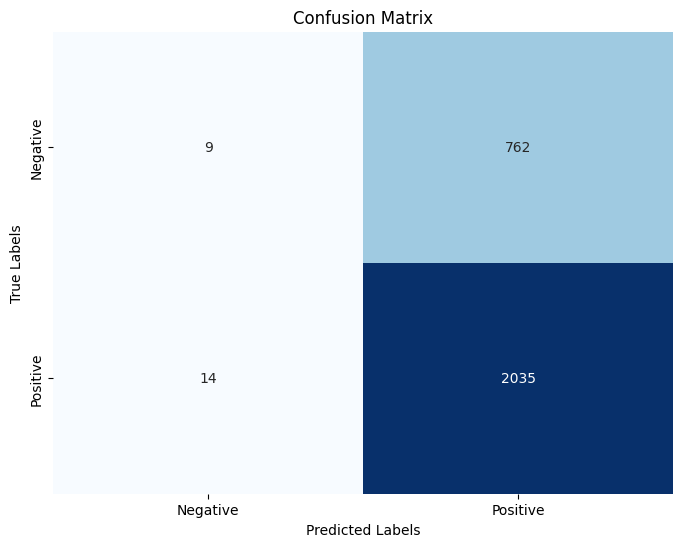

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 加载微调后的模型和分词器
model_path = "./fine_tuned_model_Erlangshen"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# 2. 定义情感预测函数
def predict_sentiments(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, axis=-1)
    return predictions.numpy()

# 3. 加载数据集
positive_file = "/content/positive_sentiment_output.csv"
negative_file = "/content/negative_sentiment_output.csv"

positive_data = pd.read_csv(positive_file, encoding="utf-8")
negative_data = pd.read_csv(negative_file, encoding="utf-8")

# 添加真实标签
positive_data["label"] = 1  # Positive
negative_data["label"] = 0  # Negative

# 合并数据集
all_data = pd.concat([positive_data, negative_data], ignore_index=True)

# 4. 预测标签
all_data["predicted_label"] = [predict_sentiments([text])[0] for text in all_data["Text"].tolist()]

# 5. 提取真实标签和预测标签
all_labels = all_data["label"].tolist()
all_predictions = all_data["predicted_label"].tolist()

# 6. 计算评估指标
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 7. 输出结果
print("=" * 30)
print(f"Accuracy: {accuracy:.4f}")
print("=" * 30)

print("\nClassification Report:")
print("-" * 30)
print(classification_rep)

print("\nConfusion Matrix:")
print("-" * 30)
print(conf_matrix)

# 8. 绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# **With no fine tune**

Accuracy: 0.4766

Classification Report:
------------------------------
              precision    recall  f1-score   support

    Negative       0.31      0.75      0.44       771
    Positive       0.80      0.37      0.51      2049

    accuracy                           0.48      2820
   macro avg       0.56      0.56      0.47      2820
weighted avg       0.67      0.48      0.49      2820


Confusion Matrix:
------------------------------
[[ 581  190]
 [1286  763]]


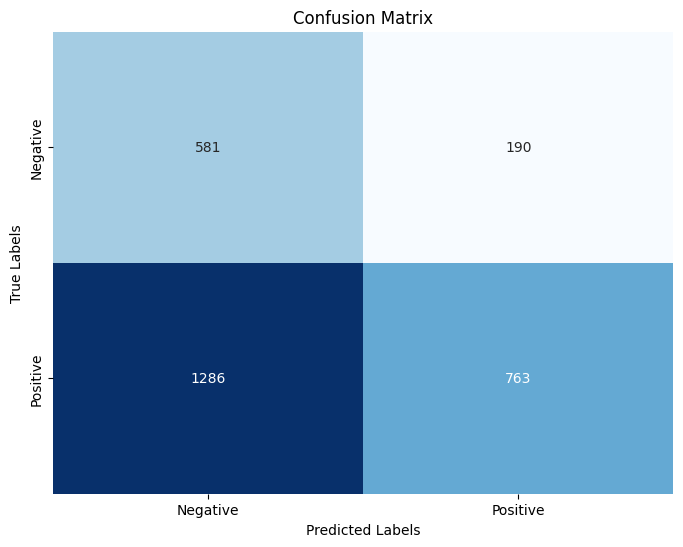

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 加载模型和分词器
model_name = "IDEA-CCNL/Erlangshen-RoBERTa-110M-Sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 2. 自定义 Dataset 类
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 3. 加载数据集
positive_file = "/content/positive_sentiment_output.csv"
negative_file = "/content/negative_sentiment_output.csv"

positive_data = pd.read_csv(positive_file, encoding="utf-8")
negative_data = pd.read_csv(negative_file, encoding="utf-8")

# 添加真实标签
positive_data["label"] = 1  # Positive
negative_data["label"] = 0  # Negative

# 合并数据集
all_data = pd.concat([positive_data, negative_data], ignore_index=True)

# 4. 创建数据集和 DataLoader
texts = all_data["Text"].tolist()
labels = all_data["label"].tolist()
test_dataset = SentimentDataset(texts, labels, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# 5. 推理过程
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, axis=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 6. 计算评估指标
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 7. 输出评估结果
print("=" * 30)
print(f"Accuracy: {accuracy:.4f}")
print("=" * 30)

print("\nClassification Report:")
print("-" * 30)
print(classification_rep)

print("\nConfusion Matrix:")
print("-" * 30)
print(conf_matrix)

# 8. 绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
